In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Manage the robot and its sensor

In [2]:
import sim

class robot():
    
    def __init__(self, frame_name, motor_names=[], sensor_name=None, client_id=0):  
        # If there is an existing connection
        if client_id:
            self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names)
        if (sensor_name is not None):
            self.sensor = self._get_handler(sensor_name)

        self.reference = self._get_handler("Cuboid1")
        # Robot frame
        self.frame = self._get_handler(frame_name)
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        print(self.client_id)
        if self.client_id != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return self.client_id
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_oneshot)
            if (err_code != 0):
                print(f"ERROR SENDING MOTOR VELS {err_code}")
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(self.client_id, self.frame, relative_object, position, sim.simx_opmode_streaming)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_orientation(self):
        err, orient = sim.simxGetObjectOrientation(self.client_id, self.frame, self.reference, sim.simx_opmode_oneshot)
        return orient
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    def read_sensor(self):
        return sim.simxReadProximitySensor(self.client_id, self.sensor, sim.simx_opmode_streaming)

In [3]:
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names, 'Proximity_sensor')

0
Robot connected


# Mapping the Enviroment

### Enviroment discretization params

In [4]:
# Overall map is 20x20 meters. Each cell is 0.4 meters, with the robot occupying about 3x2 cells. 
n = 50

# 20 since 20x20 map size
cell_w = 20/n

# Any value above this for the log_odds attribute is viewed as blocked. 
blocked_min_val = 1

In [5]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

# Plot a representation of the map of the world
def plot_world(world, path=None):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')

    # normalize world mapping
    normalized_log_odds = world['log_odds'] - np.amin(world['log_odds'])
    max_diff = np.amax(normalized_log_odds)
    if not max_diff == 0:
        normalized_log_odds = normalized_log_odds / max_diff

    # plot each cell
    for c, x, y in zip(normalized_log_odds.flatten(), world['x'].flatten(), world['y'].flatten()):
        X, Y = points_cell(x, y, cell_w)
        cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c ** 2))

        ax.add_patch(cell)

        plot(X,Y, 'midnightblue')
#         plot(X,Y, 'b+')
    if path is not None:
        for map_loc in path:
            plot(map_loc['x'] + cell_w / 2, map_loc['y'] + cell_w / 2, 'go')
    fig.canvas.draw()

### Setup initial mapping

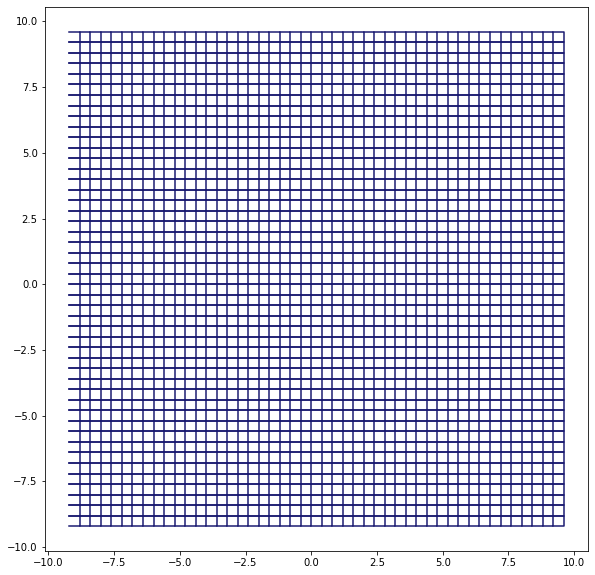

In [6]:
l0 = 0.3/(1-0.3)  # Initial belief
# log_odds: odds theres an obstacle at the index
# is_blocked: if the location is inaccessible (i.e. all places around it are blocked)
# last_cleaned: timestamp of when the robot last "cleaned" (visited) the location
# x: x position in CoppeliaSim units (meters I think?)
# y: y position in CoppeliaSim units
# visited: a value used to help with djikstras
world_map = ones((n - 3, n - 3), dtype=[('log_odds', float),('is_blocked', bool), ('last_cleaned', int), ('x', float), ('y', float), ('visited', bool)])

def reset_world_map():
    world_map['log_odds'] = l0
    world_map['is_blocked'] = False
    world_map['last_cleaned'] = 0

    # This prevents traversing the edge of the graph (since the robot may fall off)
    grid_x, grid_y = np.mgrid[-10+2*cell_w:10-cell_w:cell_w,-10+2*cell_w:10-cell_w:cell_w]

    world_map['x'] = grid_x
    world_map['y'] = grid_y

reset_world_map()
    
plot_world(world_map)

# Navigate Through World

### Find target cell

In [7]:
def find_target():
    # Can't visit a blocked cell
    unblocked_map = world_map[world_map['is_blocked'] == False]
    # Find locations where we aren't certain whether or there's an obstacle
    unknown_map = unblocked_map[(unblocked_map['log_odds'] > 0) & (unblocked_map['log_odds'] < blocked_min_val)]
    if (unknown_map.size > 0):
        return unknown_map[np.argmin(unknown_map['log_odds'])]
    return unblocked_map[np.argmin(unblocked_map['last_cleaned'])]

### Get Robots Current Cell

In [8]:
def get_rob_cell_pos():
    pos = r.get_position()
    # Not super intuative math
    x = round(pos[0] / cell_w) * cell_w
    y = round(pos[1] / cell_w) * cell_w
    return x, y

### Get world_map value from coppeliaSim x, y value

In [9]:
def get_world_map_val(x, y):
    x_index = round(x / cell_w + 10 / cell_w) - 2
    y_index = round(y / cell_w + 10 / cell_w) - 2
    if (x_index >= (n - 3) or y_index >= (n - 3) or x_index < 0 or y_index < 0):
        return None
    return world_map[x_index][y_index]

### Get the corresponding robot world_map cell

In [10]:
def get_rob_world_map():
    x, y = get_rob_cell_pos()
    x_index = round(x / cell_w + 10 / cell_w) - 2
    y_index = round(y / cell_w + 10 / cell_w) - 2
    if x_index >= (n - 3):
        x_index = n - 3
    elif x_index < 0:
        x_index = 0
    if y_index >= (n - 3):
        y_index = n - 3
    elif y_index < 0:
        y_index = 0
    return world_map[x_index][y_index]

### Find directions to target

going from (0.42857143, False, 0, 7.6, 8.4, False) to (0.42857143, False, 0, -9.2, -9.2, False)


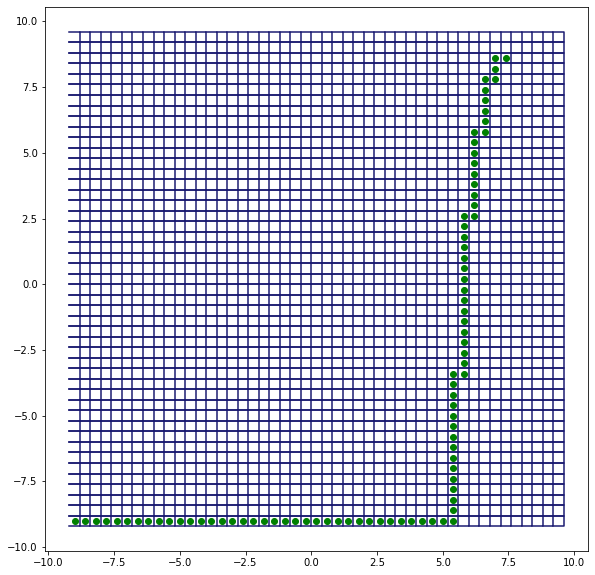

In [11]:
from queue import PriorityQueue

class QueueEntry(object):

    def __init__(self, net_weight, pos, path):
        self.net_weight = net_weight
        self.pos = pos
        self.path = path

    def __lt__(self, other):
        return self.net_weight < other.net_weight

def directions_to_target():
    world_map['visited'] = False
    current_pos = get_rob_world_map()
    target_pos = find_target()
    print(f"going from {current_pos} to {target_pos}")
    
    queue = PriorityQueue()
    path = []
    net_weight = 0
    
    queue.put(QueueEntry(net_weight, current_pos, path))
    current_pos['visited'] = True
    def add_vertex(x, y):
        next_map_val = get_world_map_val(x, y)
        if (next_map_val == None or next_map_val['visited']):
            return False
        if (next_map_val['x'] == target_pos['x'] and next_map_val['y'] == target_pos['y']):
            return True
        if next_map_val['log_odds'] > blocked_min_val:
            return False
        if next_map_val['is_blocked']:
            print(f"Blocked vertex is not blocked: {next_map_val}")
            next_map_val['is_blocked'] = False
        path_copy = path.copy()
        path_copy.append(next_map_val)
        next_map_val['visited'] = True
        queue.put(QueueEntry(net_weight + next_map_val['last_cleaned'], next_map_val, path_copy))
        
              
    
    while not queue.empty():
        queue_entry = queue.get()
        net_weight = queue_entry.net_weight
        map_pos = queue_entry.pos
        path = queue_entry.path
        x = map_pos['x']
        y = map_pos['y']
        
        if (add_vertex(x + cell_w, y) or add_vertex(x, y + cell_w) or 
            add_vertex(x - cell_w, y) or add_vertex(x, y - cell_w)):
            path.append(target_pos)
            return path
    # Unable to find directions to target (must be blocked!)
    get_world_map_val(target_pos['x'], target_pos['y'])['is_blocked'] = True
#     print(target_pos)
    return directions_to_target()
path = directions_to_target()
plot_world(world_map, path)

### Get robot orientation

In [12]:
def robot_direction():
    rot = r.get_orientation()[2]
    if (rot <= pi / 4 and rot > -pi / 4):
        return "-y"
    elif (rot <= 3 * pi / 4 and rot > pi / 4):
        return "+x"
    elif (rot >= 3 * pi / 4 or rot <= -3 * pi / 4):
        return "+y"
    else:
        return "-x"

### Get the vertexes contained within the robot's current position

In [13]:
def robot_occupied_mappings():
    x, y = get_rob_cell_pos()
    occupied_cells = [get_world_map_val(x, y)]
    
#     if "x" in robot_direction():
#         # Facing X orientation
#         occupied_cells.append(get_world_map_val(x + cell_w, y))
#         occupied_cells.append(get_world_map_val(x - cell_w, y))
#     else:
#         # Facing Y orientation
#         occupied_cells.append(get_world_map_val(x, y + cell_w))
#         occupied_cells.append(get_world_map_val(x, y - cell_w))
    occupied_cells = filter(lambda x: x is not None, occupied_cells)
    return occupied_cells

### Update surroundings

In [14]:
import time

# Returns true if there was a substantive change to the map (meaning the directions have to be recalculated)
def update_surroundings():
    current_time = int(round(time.time() * 1000))
    for occupied_mapping in robot_occupied_mappings():
        occupied_mapping['last_cleaned'] = current_time
        po = 0.1
        occupied_mapping['log_odds'] = log(po / (1-po)) + occupied_mapping['log_odds'] - l0
    err, found, _, _, _ = r.read_sensor()
#     sensor_mapping
    x, y = get_rob_cell_pos()
    rob_dir = robot_direction()
#     multiplier
    if "-" in rob_dir:
        multiplier = -1
    else:
        multiplier = 1
    if "x" in rob_dir:
        sensor_mapping = get_world_map_val(x + multiplier * cell_w, y)
    else:
        sensor_mapping = get_world_map_val(x, y + multiplier * cell_w)
    if sensor_mapping is not None:
        if found:
            po = 0.90 # Probability of obstacle
            done = False
            if (sensor_mapping['log_odds'] < blocked_min_val):
                done = True
            sensor_mapping['log_odds'] = log(po / (1-po)) + sensor_mapping['log_odds'] - l0
            if done:
                print("BREAK!")
                return True
        else:
            po = 0.2
            sensor_mapping['log_odds'] = log(po / (1-po)) + sensor_mapping['log_odds'] - l0
            # Doesn't really matter if something was marked as blocked, but really isn't (it'll just deal with it during the next search)

### Navigate through surroundings

In [15]:
def compute_dist(p1, p2):
    x_diff = p1[0] - p2[0]
    y_diff = p1[1] - p2[1]
    sign = 1
    rob_dir = robot_direction()
    if "x" in rob_dir:
        if x_diff < 0:
            sign = -1
    else:
        if y_diff < 0:
            sign = -1
    if "-" not in rob_dir:
        sign = -sign
    return sign * sqrt(x_diff ** 2 + y_diff ** 2)

def traj(tf, desired_pos):
    global starting_pos
    
    rob_dir = robot_direction()
    
    start_time = time.time()
    # Time interval
    time_step = 0.05
    time_steps = linspace(0, tf, round(tf / time_step))

    a1 = (desired_pos - starting_pos) / tf
    a0 = starting_pos
    robot_position = r.get_position()
        
    for t in time_steps:
        point_traj = a1 * t + a0

        # Sensing
        robot_position = r.get_position()
        orient = pi - r.get_orientation()[2]
        disk.set_position(point_traj)

        # Trajectory tracker
        vx = 0
        vy = -20 * compute_dist(robot_position, point_traj)
        
        r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
        tim = time.time()
        if (tim - start_time < (t + time_step)):
            time.sleep((t + time_step) - (tim - start_time))
    starting_pos = desired_pos
    
def rotate_to_angle(desired):
    orient = r.get_orientation()
    while abs(orient[2] - desired) > 0.05:
        rot_speed = (orient[2] - desired) * 4
        r.send_motor_velocities([rot_speed, rot_speed, rot_speed, rot_speed])
        time.sleep(0.02)
        orient = r.get_orientation()

# Do the navigation!

### Reset Map?

In [16]:
reset_world_map()

### Traverse Map

In [17]:
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names, 'Proximity_sensor')
disk = robot('Disc', client_id=r.client_id)

starting_pos = r.get_position()
while True:
    r.send_motor_velocities([0, 0, 0, 0])
    path = directions_to_target()
    for mapping in path:
        if (update_surroundings()):
            print("surroundings updated")
            break
        x_diff = starting_pos[0] - mapping['x']
        y_diff = starting_pos[1] - mapping['y']
        if (abs(x_diff) > abs(y_diff)):
            # Likely moving in x direction
            if (x_diff > 0):
                target_orient = -pi/2
            else:
                target_orient = pi/2
        else:
            if (y_diff > 0):
                # Not great since -pi also works
                target_orient = 0
            else:
                target_orient = -pi
        rotate_to_angle(target_orient)
        if (update_surroundings()):
            print("surroundings updated")
            break
        traj(0.5, array([mapping['x'], mapping['y'], 0.1]))
r.send_motor_velocities([0, 0, 0, 0])

0
Robot connected
0
Robot connected
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1
going from (0.42857143, False, 0, 7.6, 8.4, False) to (0.42857143, False, 0, -9.2, -9.2, False)
BREAK!
surroundings updated
going from (-5.82695616, False, 1608163772384, 6.4, 6., False) to (0.42857143, False, 0, -9.2, -9.2, False)
BREAK!
surroundings updated
going from (-8.45275216, False, 1608163778186, 5.6, 6., False) to (0.42857143, False, 0, -9.2, -9.2, False)
BREAK!
surroundings updated
going from (-8.45275216, False, 1608163782965, 5.2, 6., False) to (0.42857143, False, 0, -9.2, -9.2, False)
BREAK!
surroundings updated
going from (-5.82695616, False, 1608163803807, 4., 2., False) to (0.42857143, False, 0, -9.2, -9.2, False)
BREAK!
surroundings updated
going from (-4.01209037, False, 1608163809521, 3.2, 1.6, False) to (0.42857143, False, 0, -9.2, -9.2, False)
BREAK!
surroundings updated
going from (-9.26368238, False, 1608163811542, 3.2, 

KeyboardInterrupt: 

[[( 0.42857143, False, 0, -9.2, -9.2, False)
  ( 0.42857143, False, 0, -9.2, -8.8,  True)
  ( 0.42857143, False, 0, -9.2, -8.4,  True) ...
  ( 0.42857143, False, 0, -9.2,  8.4, False)
  ( 0.42857143, False, 0, -9.2,  8.8, False)
  ( 0.42857143, False, 0, -9.2,  9.2, False)]
 [( 0.42857143, False, 0, -8.8, -9.2,  True)
  ( 0.42857143, False, 0, -8.8, -8.8,  True)
  ( 0.42857143, False, 0, -8.8, -8.4,  True) ...
  ( 0.42857143, False, 0, -8.8,  8.4, False)
  ( 0.42857143, False, 0, -8.8,  8.8, False)
  ( 0.42857143, False, 0, -8.8,  9.2, False)]
 [( 0.42857143, False, 0, -8.4, -9.2,  True)
  ( 0.42857143, False, 0, -8.4, -8.8,  True)
  ( 0.42857143, False, 0, -8.4, -8.4,  True) ...
  (-1.38629436, False, 0, -8.4,  8.4, False)
  ( 0.42857143, False, 0, -8.4,  8.8, False)
  ( 0.42857143, False, 0, -8.4,  9.2, False)]
 ...
 [( 0.42857143, False, 0,  8.4, -9.2,  True)
  ( 0.42857143, False, 0,  8.4, -8.8,  True)
  ( 0.42857143, False, 0,  8.4, -8.4,  True) ...
  ( 0.42857143, False, 0,  8.4,

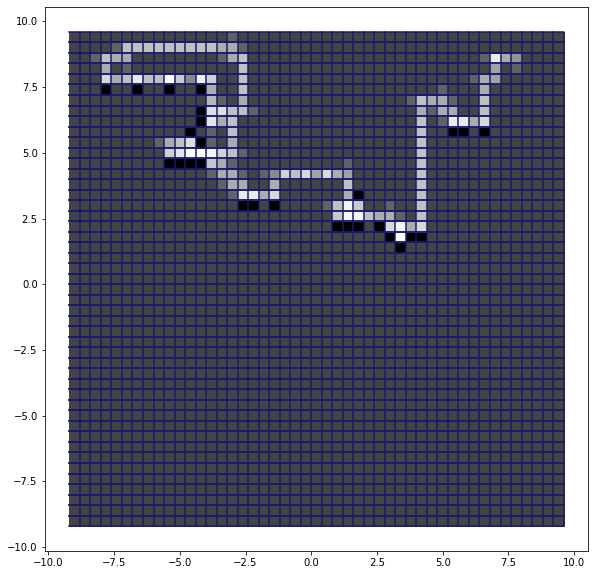

In [20]:
print(world_map)
plot_world(world_map)